# Rolling Average Forecasts

The first forecasting method we will investigate uses some kind of average of the value at previous time steps to predict the next time step.

## What we will accomplish

In this notebook we will:
- Introduce the concept behind averaging or smoothing
- Define a rolling average forecast
- Build upon that with a weighted rolling average forecast

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from seaborn import set_style
from sklearn.metrics import mean_squared_error

set_style("whitegrid")

## What is an averaging/smoothing forecast

An averaging or smoothing forecast is one in which we take an average of some collection of previous values to predict the future value.

### Rolling average forecast

For example,

$$
y_{t+1} = \frac{1}{3}\left(y_t + y_{t-1} + y_{t-2} \right)
$$

is a rolling averaging forecast.

WARNING:  This is also known as a "moving average" in some circles.  We will discuss ARIMA (Auto Regressive Integrated Moving Average) models next week.  Our use of the term "Moving Average" there is **not** the same as the "rolling average" we are discussing here.  We are using the term "rolling average" in this notebook to avoid confusion in the ARIMA notebooks. However, you should be aware of this terminological confusion.

The rolling average forecast with window size $q$ and equal weights is:

$$
y_{t+1} = \left\lbrace \begin{array}{l c c} \frac{1}{q} \displaystyle \sum_{i=0}^{q-1} y_{t-i} & \text{for} & t \leq n-1 \\
\frac{1}{q} \displaystyle \sum_{i=0}^{q-1} y_{n-i} & \text{for} & t \geq n \end{array} \right\rbrace
$$

Note that this is a forecasting method only:  there is no underlying statistical model here.

We can implement this on the Google stock data.

In [2]:
goog = pd.read_csv("../../data/google_stock.csv", parse_dates=['date'])

goog_train = goog.iloc[:-14].copy()
goog_test = goog.iloc[-14:].copy()

`pandas` has nice functionality for computing rolling averages called `rolling`, <a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html">https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html</a>.

In [3]:
## To use rolling
## specify the column you want the rolling average of
## give the window size as the argument
## then give what you want the rolling statistic of, we want the mean()
## Finally set the argument closed='left' to ensure that y_{t+1} is the average
## of the previous k values.
pd.DataFrame({'closing_price':goog_train.closing_price,
                  'rolling_avg':goog_train.closing_price.rolling(3,
                                                                closed='left').mean()})

,closing_price,rolling_avg
0,49.982655,NaN
1,53.952770,NaN
2,54.495735,NaN
3,52.239197,52.810387
4,52.802086,53.562567
...,...,...
4413,2683.360107,2680.559977
4414,2695.030029,2690.523356
4415,2686.159912,2692.070068
4416,2642.439941,2688.183349


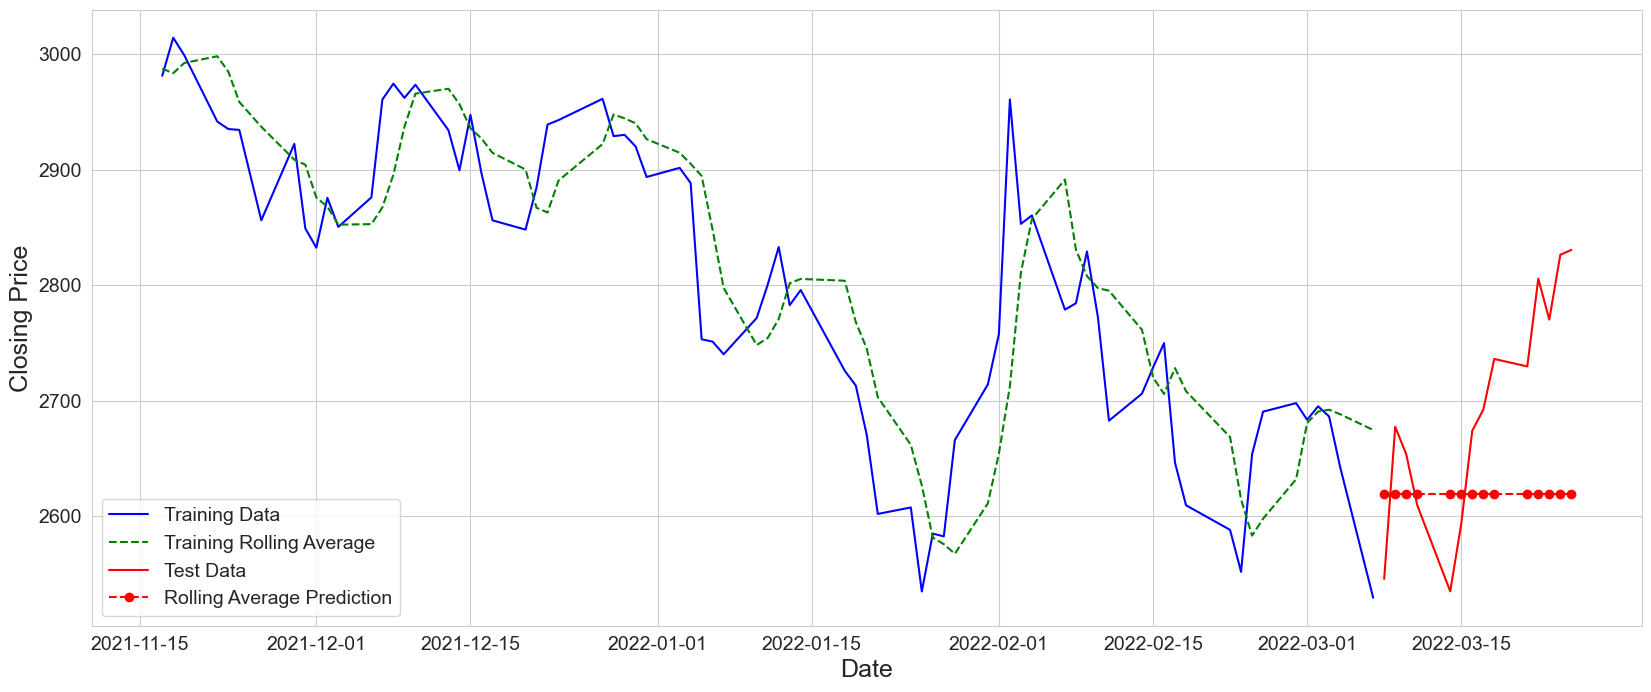

In [4]:
plt.figure(figsize=(20,8))


plt.plot(goog_train.date[-75:], 
         goog_train.closing_price[-75:],
         'b',
         label="Training Data")

plt.plot(goog_train.date[-75:], 
         goog_train.closing_price.rolling(3, closed="left").mean()[-75:],
         'g--',
         label="Training Rolling Average")

plt.plot(goog_test.date, 
         goog_test.closing_price,
         'r',
         label="Test Data")

plt.plot(goog_test.date, 
         goog_train.closing_price[-3:].mean()*np.ones(14),
         'r--o',
         label="Rolling Average Prediction")

plt.xlabel("Date", fontsize=18)
plt.ylabel("Closing Price", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14, loc=3)

plt.show()

As you may have noticed, the rolling average tends to lag behind the actual data. This is a weakness of the model.

Rolling averages can be used for more than just making forecasts. We can also use them to look for trends or patterns in the data set. This can be accomplished by changing the window size.

For example, below as we increase the window size we start to reveal the increasing trend of the data set. While we could have identified this trend without the rolling average, there are some noisier data sets in which patterns are more difficult to identify and the rolling average can help us find hard to see seasonality or trends.

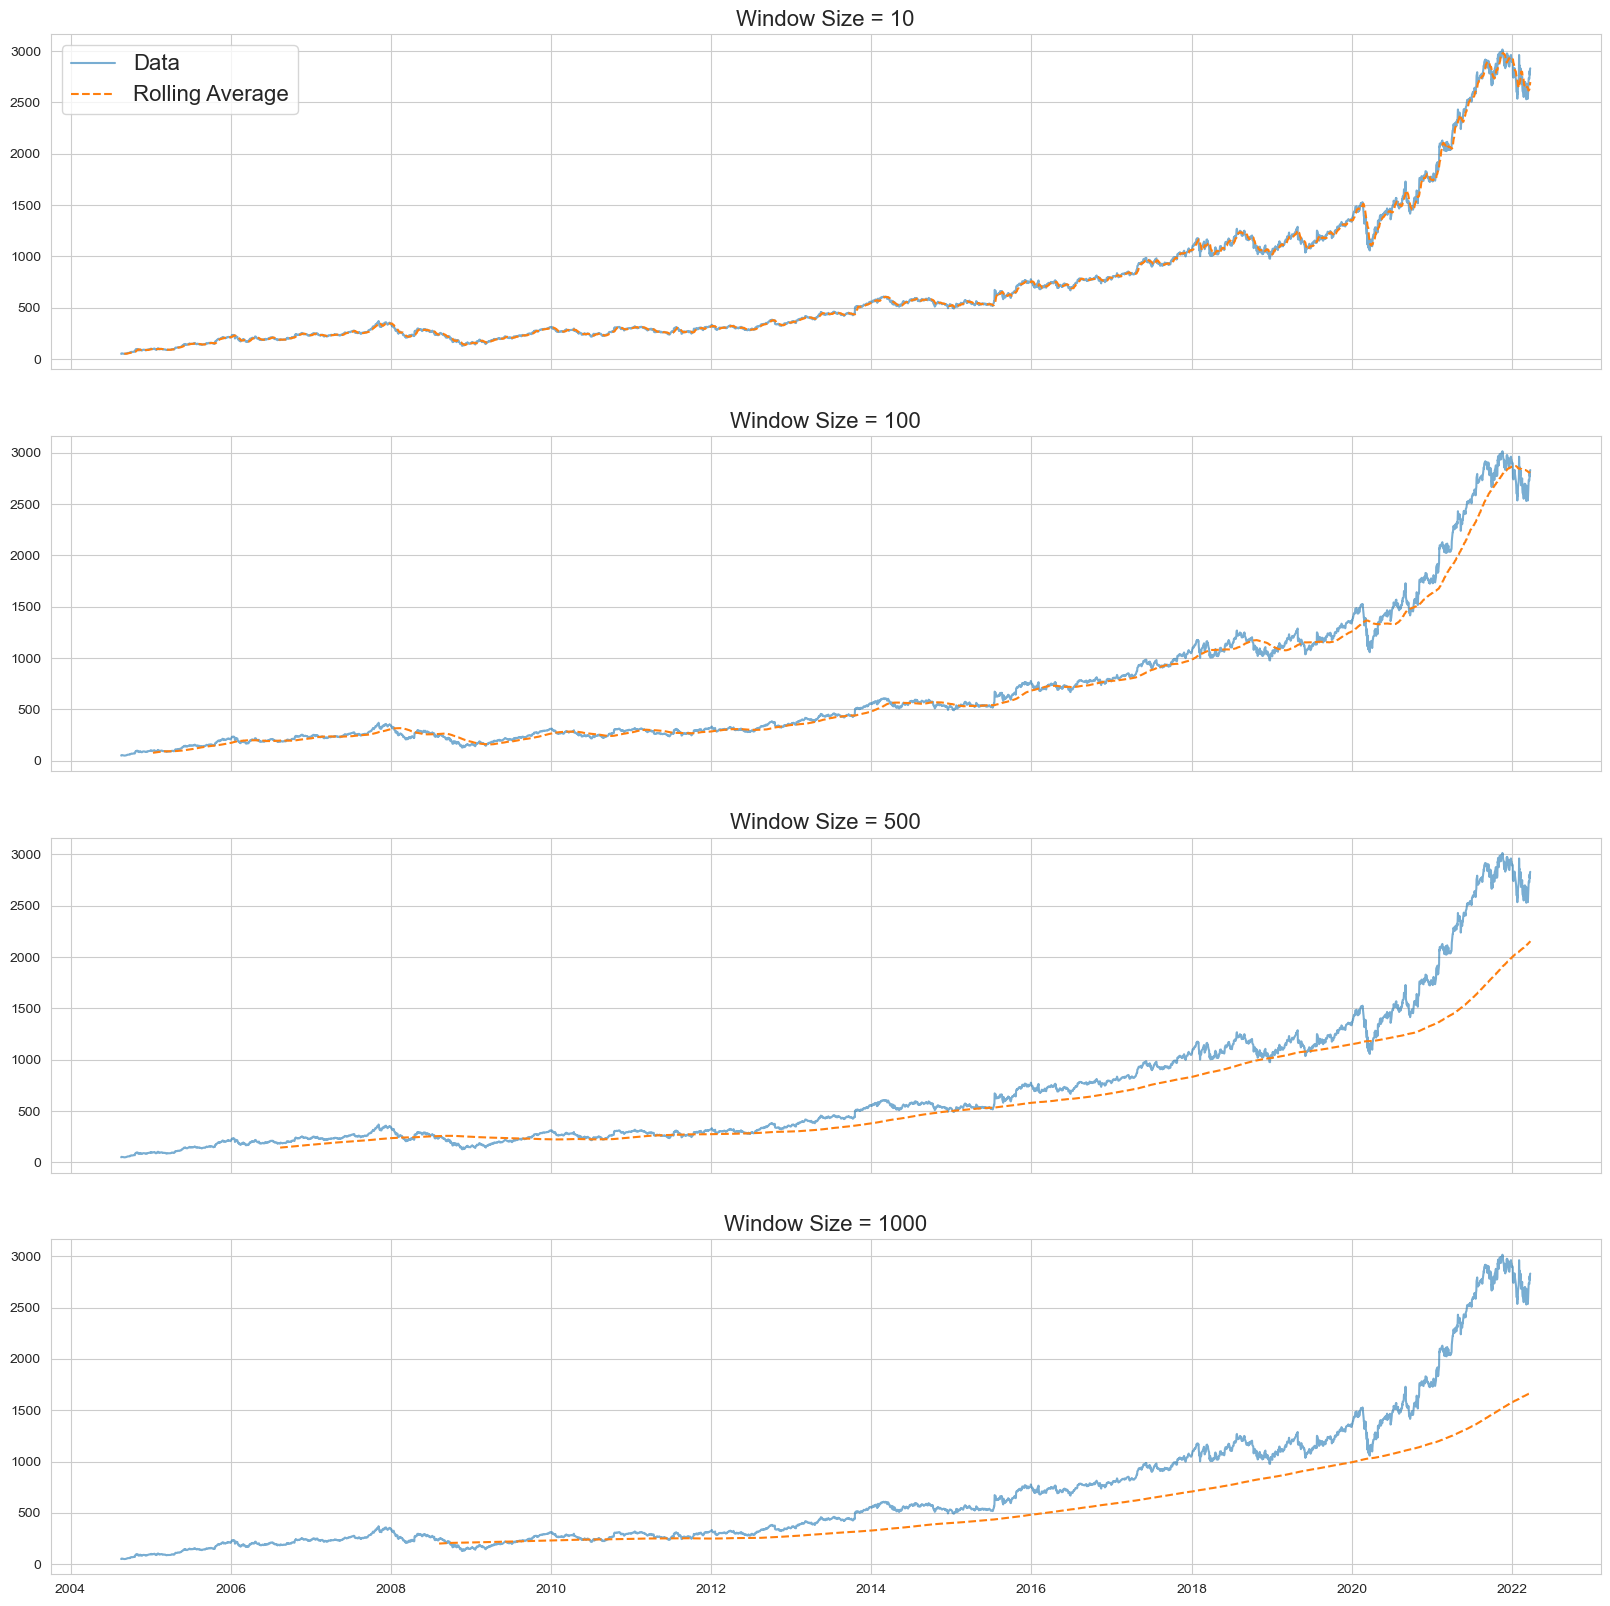

In [5]:
fig,ax = plt.subplots(4, 1, figsize=(20,20), sharex=True, sharey=True)

ax[0].plot(goog.date, 
           goog.closing_price,
           alpha=.6,
           label="Data")
ax[0].plot(goog.date, 
           goog.closing_price.rolling(10, closed='left').mean(),
           '--',
           linewidth=1.5,
           label="Rolling Average")

ax[0].legend(fontsize=16)
ax[0].set_title("Window Size = 10", fontsize=16)

ax[1].plot(goog.date, 
           goog.closing_price,
           alpha=.6,
           label="Data")
ax[1].plot(goog.date, 
           goog.closing_price.rolling(100, closed='left').mean(),
           '--',
           linewidth=1.5,
           label="Rolling Average")
ax[1].set_title("Window Size = 100", fontsize=16)


ax[2].plot(goog.date, 
           goog.closing_price,
           alpha=.6,
           label="Data")
ax[2].plot(goog.date, 
           goog.closing_price.rolling(500, closed='left').mean(),
           '--',
           linewidth=1.5,
           label="Rolling Average")
ax[2].set_title("Window Size = 500", fontsize=16)


ax[3].plot(goog.date, 
           goog.closing_price,
           alpha=.6,
           label="Data")
ax[3].plot(goog.date, 
           goog.closing_price.rolling(1000, closed='left').mean(),
           '--',
           linewidth=1.5,
           label="Rolling Average")
ax[3].set_title("Window Size = 1000", fontsize=16)




# plt.xlabel("Date", fontsize=18)
# plt.ylabel("Closing Price", fontsize=18)

# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

plt.show()

### More general weighted rolling average forecasts

To this point we have only considered average forecasts in which each previous time point considered has been given equal weight. You can more generally apply disproportionate weighting, for example if you wanted to give more weight to the recent observations.

As an example we will visualize the following weighted rolling average forecast on the Google data:

$$
y_{t} = \left\lbrace \begin{array}{l c c} \frac{2}{3}y_{t-1} + \frac{1}{6}y_{t-2} + \frac{1}{6} y_{t-3} & \text{for} & t \leq n-1 \\
\frac{2}{3}y_{n-1} + \frac{1}{6}y_{n-2} + \frac{1}{6} y_{n-3} & \text{for} & t \geq n \end{array} \right\rbrace
$$

In [6]:
def weight_avg(t):
    return (2/3)*goog_train.closing_price.values[t-1] + (1/6)*goog_train.closing_price.values[t-2] + (1/6)*goog_train.closing_price.values[t-3]

goog_train_fit = []

for i in range(3,len(goog_train)):
    goog_train_fit.append(weight_avg(i))
        
        
pred = weight_avg(len(goog_train))

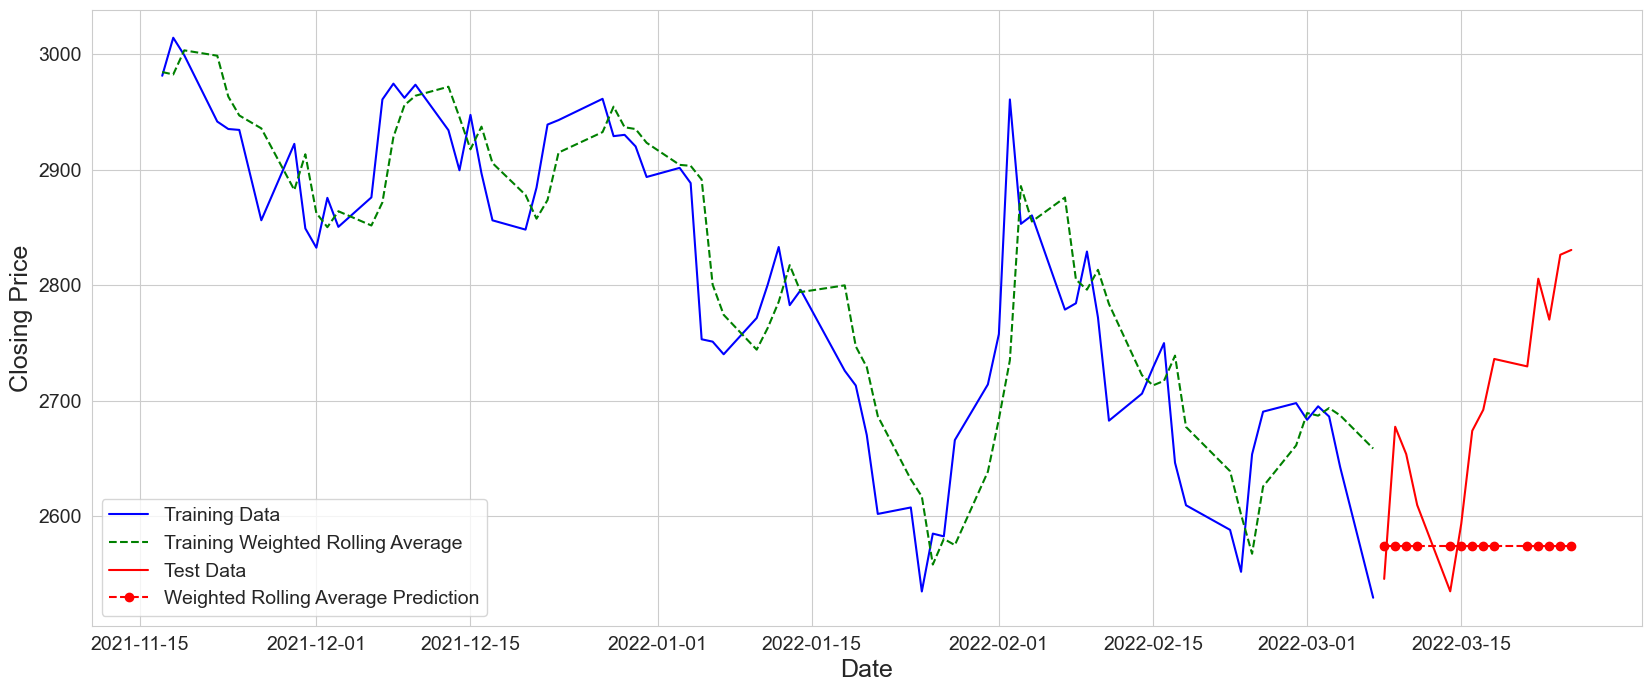

In [7]:
plt.figure(figsize=(20,8))


plt.plot(goog_train.date[-75:], 
         goog_train.closing_price[-75:],
         'b',
         label="Training Data")



plt.plot(goog_train.date[-75:], 
         goog_train_fit[-75:],
         'g--',
         label="Training Weighted Rolling Average")

plt.plot(goog_test.date, 
         goog_test.closing_price,
         'r',
         label="Test Data")

plt.plot(goog_test.date, 
         pred*np.ones(14),
         'r--o',
         label="Weighted Rolling Average Prediction")

plt.xlabel("Date", fontsize=18)
plt.ylabel("Closing Price", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14, loc=3)

plt.show()

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2023.  Modified by Steven Gubkin 2024.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)